# 📊 Complete Chart Gallery - All 51 Visualizations

Run each cell to generate and view all charts from the analysis.

---

In [69]:
# === SETUP ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Color palette
COLORS = {
    'nl': '#D55E00', 'usa': '#0072B2', 'israel': '#009E73',
    'uk': '#56B4E9', 'germany': '#E69F00', 'france': '#CC79A7',
    'gray': '#999999', 'success': '#009E73', 'failure': '#D55E00',
    'orange': '#E69F00', 'skyblue': '#56B4E9', 'green': '#009E73',
    'blue': '#0072B2', 'vermillion': '#D55E00', 'purple': '#CC79A7'
}

def tufte_style(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('#666666')
    ax.spines['bottom'].set_color('#666666')
    ax.tick_params(colors='#666666')
    ax.grid(False)
    return ax

# Load data - CORRECT PATH
df = pd.read_csv('../investments_VC.csv', encoding='latin-1')
df.columns = df.columns.str.strip()
df['market'] = df['market'].str.strip()
df['country_code'] = df['country_code'].str.strip()

# Parse dates
df['founded_at'] = pd.to_datetime(df['founded_at'], errors='coerce')
df['first_funding_at'] = pd.to_datetime(df['first_funding_at'], errors='coerce')
df['last_funding_at'] = pd.to_datetime(df['last_funding_at'], errors='coerce')
df['funding_total_usd'] = pd.to_numeric(
    df['funding_total_usd'].astype(str).str.replace(',','').str.replace(' ','').str.replace('-',''),
    errors='coerce'
)

# Filter to 2005-2014
df = df[df['first_funding_at'].notna()]
df = df[(df['first_funding_at'].dt.year >= 2005) & (df['first_funding_at'].dt.year <= 2014)]

# Create analysis columns
for col in ['seed', 'round_A', 'round_B', 'round_C', 'round_D', 'venture', 'angel', 'funding_rounds']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce').fillna(0)

df['had_seed'] = df['seed'] > 0
df['had_series_a'] = df['round_A'] > 0
df['had_series_b'] = df['round_B'] > 0
df['had_series_c'] = df['round_C'] > 0
df['acquired'] = df['status'] == 'acquired'
df['failed'] = df['status'] == 'closed'
df['exited'] = df['status'].isin(['acquired', 'ipo'])
df['operating'] = df['status'] == 'operating'

# Benchmark countries
COUNTRIES = {'NLD': 'Netherlands', 'USA': 'USA', 'ISR': 'Israel', 
             'GBR': 'UK', 'DEU': 'Germany', 'FRA': 'France'}
country_colors = {'Netherlands': COLORS['nl'], 'USA': COLORS['usa'], 'Israel': COLORS['israel'],
                  'UK': COLORS['uk'], 'Germany': COLORS['germany'], 'France': COLORS['france']}

benchmark_df = df[df['country_code'].isin(COUNTRIES.keys())].copy()
benchmark_df['country'] = benchmark_df['country_code'].map(COUNTRIES)

nl_df = df[df['country_code'] == 'NLD']
us_df = df[df['country_code'] == 'USA']

# Timing column
df['years_to_funding'] = (df['first_funding_at'] - df['founded_at']).dt.days / 365.25
df_timing = df[(df['years_to_funding'] >= 0) & (df['years_to_funding'] <= 15)]

print(f'✅ Loaded {len(df):,} companies')
print(f'✅ Dutch companies: {len(nl_df):,}')
print(f'✅ Benchmark countries: {len(benchmark_df):,}')

✅ Loaded 48,163 companies
✅ Dutch companies: 305
✅ Benchmark countries: 33,364


---
# TIER 1: TOP 10 CHARTS (Score 21-24)
---

CHART #1: Seed→Series A Conversion Gap BY TIME PERIOD


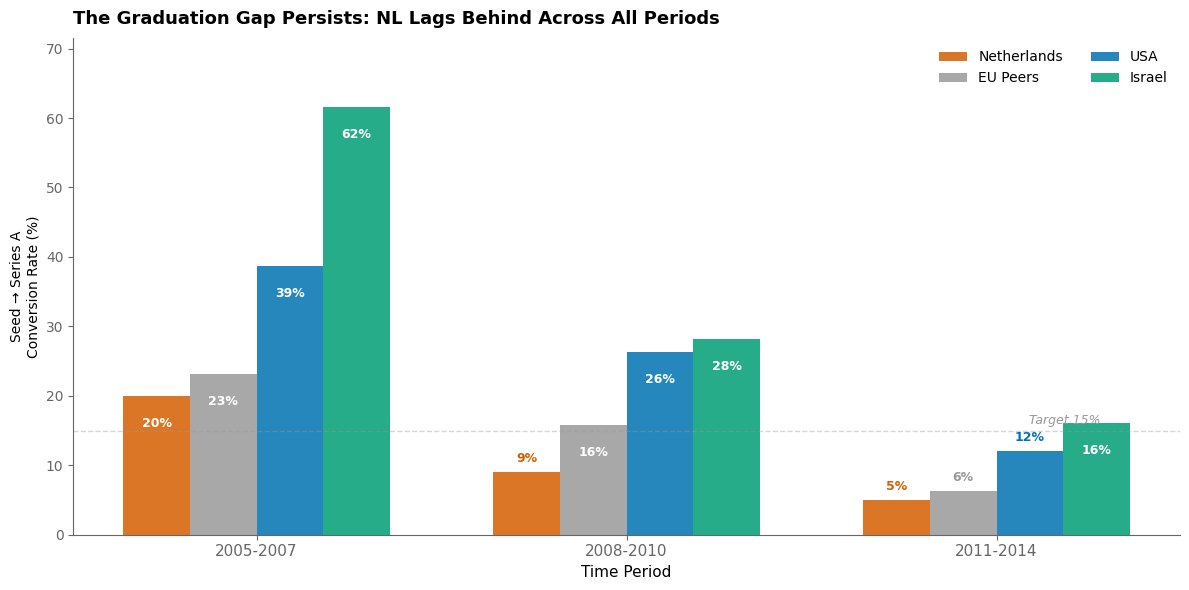


📊 Seed→Series A Conversion by Period:
--------------------------------------------------

2005-2007:
  Netherlands: 20.0% (n=5)
  EU Peers: 23.1% (n=78)
  USA: 38.6% (n=321)
  Israel: 61.5% (n=13)

2008-2010:
  Netherlands: 9.1% (n=11)
  EU Peers: 15.7% (n=216)
  USA: 26.3% (n=1245)
  Israel: 28.1% (n=32)

2011-2014:
  Netherlands: 4.9% (n=81)
  EU Peers: 6.3% (n=947)
  USA: 12.1% (n=5404)
  Israel: 16.1% (n=137)


In [70]:
# === CHART #1: finding1_graduation_gap.png (Score: 24) ===
print('CHART #1: The Graduation Gap')

# Add funding year for period analysis
df['funding_year'] = df['first_funding_at'].dt.year

def seed_to_a_rate_period(codes, year_start, year_end):
    """Calculate Seed→A conversion for a specific time period"""
    if isinstance(codes, str): codes = [codes]
    subset = df[(df['country_code'].isin(codes)) & 
                (df['funding_year'] >= year_start) & 
                (df['funding_year'] <= year_end)]
    with_seed = subset[subset['had_seed']]
    with_a = with_seed[with_seed['had_series_a']]
    if len(with_seed) < 5:  # Minimum sample size
        return np.nan, len(with_seed)
    return len(with_a) / len(with_seed) * 100, len(with_seed)

# Define regions and time periods
regions = ['Netherlands', 'EU Peers', 'USA', 'Israel']
region_codes = [['NLD'], ['GBR', 'DEU', 'FRA'], ['USA'], ['ISR']]
region_colors = [COLORS['vermillion'], COLORS['gray'], COLORS['blue'], COLORS['green']]

periods = [('2005-2007', 2005, 2007), ('2008-2010', 2008, 2010), ('2011-2014', 2011, 2014)]
period_labels = [p[0] for p in periods]

# Calculate rates for each region and period
fig, ax = plt.subplots(figsize=(12, 6))
tufte_style(ax)

x = np.arange(len(period_labels))
width = 0.18
multiplier = 0

# First pass: collect all rates to determine y-axis max
all_rates = []
for region, codes, color in zip(regions, region_codes, region_colors):
    for label, start, end in periods:
        rate, n = seed_to_a_rate_period(codes, start, end)
        if pd.notna(rate):
            all_rates.append(rate)

y_max = max(all_rates) + 10 if all_rates else 70  # Add padding

# Second pass: draw bars
for region, codes, color in zip(regions, region_codes, region_colors):
    rates = []
    for label, start, end in periods:
        rate, n = seed_to_a_rate_period(codes, start, end)
        rates.append(rate)
    
    offset = width * multiplier
    bars = ax.bar(x + offset, rates, width, label=region, color=color, alpha=0.9)
    
    # Add value labels INSIDE bars (at top) to avoid overlap
    for bar, rate in zip(bars, rates):
        if pd.notna(rate):
            # Position label inside bar if bar is tall enough, otherwise above
            label_y = bar.get_height() - 2 if bar.get_height() > 5 else bar.get_height() + 0.5
            label_color = 'white' if bar.get_height() > 5 else color
            ax.text(bar.get_x() + bar.get_width()/2, label_y,
                    f'{rate:.0f}%', ha='center', va='bottom' if bar.get_height() <= 5 else 'top', 
                    fontsize=8, color=label_color, fontweight='bold')
    
    multiplier += 1

ax.set_xticks(x + width * 1.5)
ax.set_xticklabels(period_labels, fontsize=11)
ax.set_ylabel('Seed → Series A\nConversion Rate (%)', fontsize=10)
ax.set_title('The Graduation Gap Persists: NL Lags Behind Across All Periods', 
             fontweight='bold', fontsize=13, loc='left', pad=15)

# Move legend to upper right, outside the bar area
ax.legend(loc='upper right', frameon=False, fontsize=10, ncol=2)

# Set proper y-axis limit
ax.set_ylim(0, y_max)

# Add reference line
ax.axhline(y=15, color=COLORS['gray'], linestyle='--', alpha=0.4, linewidth=1)
ax.text(2.65, 16, 'Target 15%', fontsize=9, color=COLORS['gray'], style='italic', ha='right')

plt.tight_layout()
plt.show()

# Print summary table
print('\n📊 Seed→Series A Conversion by Period:')
print('-' * 50)
for label, start, end in periods:
    print(f'\n{label}:')
    for region, codes in zip(regions, region_codes):
        rate, n = seed_to_a_rate_period(codes, start, end)
        if pd.notna(rate):
            print(f'  {region}: {rate:.1f}% (n={n})')


In [ ]:
# === CHART #2: Playing It Small — Final Version ===
print('CHART #2: Playing It Small')

import matplotlib.pyplot as plt
import numpy as np

# Data
def get_metrics(codes):
    subset = df[df['country_code'].isin(codes)]
    n = len(subset)
    failure = (subset['status'] == 'closed').sum() / n * 100
    exit_rate = subset['exited'].sum() / n * 100
    median_funding = subset['funding_total_usd'].median() / 1e6
    return {'failure': failure, 'exit': exit_rate, 'funding': median_funding, 'n': n}

regions = ['USA', 'Israel', 'EU Peers', 'Netherlands']
codes = {'USA': ['USA'], 'Israel': ['ISR'], 'EU Peers': ['GBR', 'DEU', 'FRA'], 'Netherlands': ['NLD']}
colors = {'USA': '#0072B2', 'Israel': '#009E73', 'EU Peers': '#888888', 'Netherlands': '#D55E00'}
data = {r: get_metrics(codes[r]) for r in regions}

fig = plt.figure(figsize=(15, 10))

# Title
fig.text(0.5, 0.95, 'Finding #2: Playing It Small', fontsize=20, fontweight='bold', ha='center')
fig.text(0.5, 0.91, 'Netherlands ranks last on all three dimensions', 
         fontsize=12, ha='center', color='#555555', style='italic')

# Column config
metrics_config = [
    ('failure', 'Failure rate', '(companies that shut down)', '%', 10),
    ('funding', 'Money raised', '(median funding)', '$M', 5),
    ('exit', 'Exit rate', '(acquired or IPO)', '%', 12),
]

for col_idx, (metric, title, subtitle, unit, max_val) in enumerate(metrics_config):
    ax = fig.add_axes([0.12 + col_idx * 0.29, 0.35, 0.24, 0.45])
    
    sorted_regions = sorted(regions, key=lambda r: data[r][metric], reverse=True)
    
    y_positions = np.arange(len(sorted_regions))
    values = [data[r][metric] for r in sorted_regions]
    bar_colors = [colors[r] for r in sorted_regions]
    
    bars = ax.barh(y_positions, values, color=bar_colors, height=0.55, 
                   edgecolor='white', linewidth=2, alpha=0.85)
    
    for rank, (region, val) in enumerate(zip(sorted_regions, values)):
        if unit == '$M':
            val_str = f'${val:.1f}M'
        else:
            val_str = f'{val:.1f}%'
        
        ax.text(val + max_val * 0.02, rank, val_str, fontsize=10, fontweight='bold',
                va='center', ha='left', color='#333333')
        
        if region == 'Netherlands':
            bars[rank].set_edgecolor('#D55E00')
            bars[rank].set_linewidth(3)
    
    rank_labels = [f'#{rank+1}  {region}' for rank, region in enumerate(sorted_regions)]
    ax.set_yticks(y_positions)
    ax.set_yticklabels(rank_labels, fontsize=10)
    
    for tick, region in zip(ax.get_yticklabels(), sorted_regions):
        if region == 'Netherlands':
            tick.set_fontweight('bold')
            tick.set_color('#D55E00')
    
    ax.invert_yaxis()
    ax.set_xlim(0, max_val * 1.15)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(bottom=False, labelbottom=False)
    
    ax.set_title(f'{title}\n{subtitle}', fontsize=12, fontweight='bold', pad=12)

# Bottom section - THE PATTERN
fig.text(0.5, 0.23, 'THE PATTERN', fontsize=12, fontweight='bold', ha='center', color='#333333')

# Draw three connected boxes with visible connectors using text
box_props = dict(boxstyle='round,pad=0.5', facecolor='#fff8f0', edgecolor='#D55E00', linewidth=2)

fig.text(0.18, 0.12, 'Low failure\n(4.3%)', fontsize=12, ha='center', va='center', 
         bbox=box_props, color='#D55E00', fontweight='bold')

# Connector 1 - using arrows
fig.text(0.34, 0.12, '―――', fontsize=14, ha='center', va='center', color='#D55E00', fontweight='bold')

fig.text(0.50, 0.12, 'Low funding\n($1.0M)', fontsize=12, ha='center', va='center',
         bbox=box_props, color='#D55E00', fontweight='bold')

# Connector 2
fig.text(0.66, 0.12, '―――', fontsize=14, ha='center', va='center', color='#D55E00', fontweight='bold')

fig.text(0.82, 0.12, 'Low exits\n(4.3%)', fontsize=12, ha='center', va='center',
         bbox=box_props, color='#D55E00', fontweight='bold')

# Subtitle
fig.text(0.5, 0.03, 'A consistent pattern: the Dutch ecosystem operates at a smaller scale across all metrics', 
         fontsize=10, ha='center', color='#666666', style='italic')

plt.savefig('figures/finding2_playing_it_small.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print('✓ Final version with visible connectors')

CHART #3: The Tortoise Effect - Patience Pays


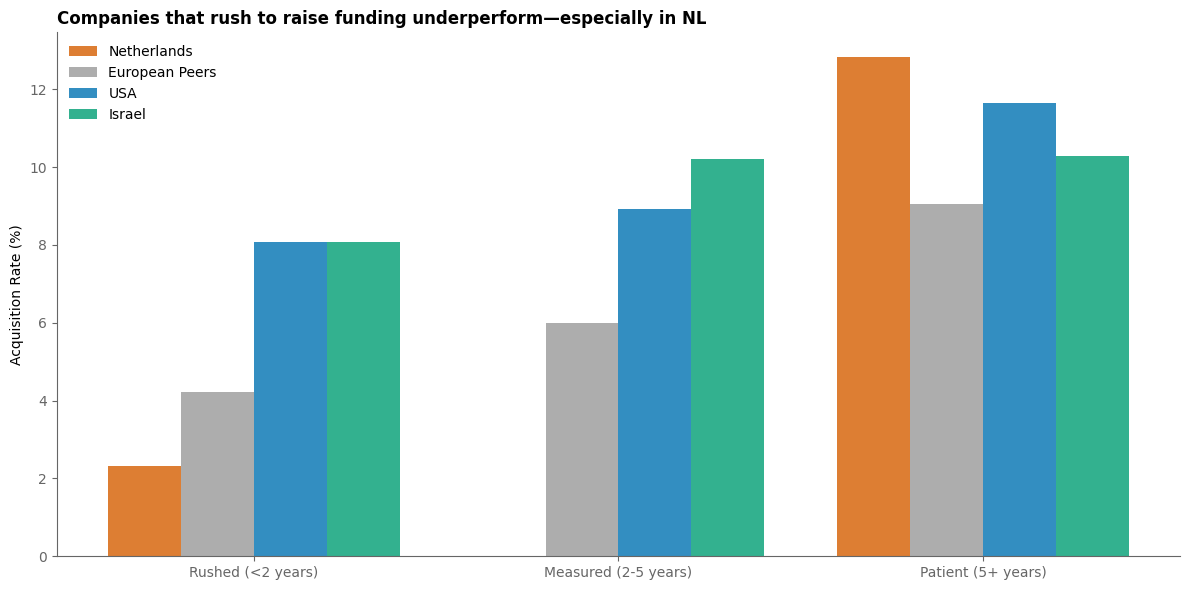

In [47]:
# === CHART #3: finding3_tortoise_effect.png (Score: 24) ===
print('CHART #3: The Patience Premium')

def bootstrap_rate(country_codes, year_range):
    if isinstance(country_codes, str): country_codes = [country_codes]
    subset = df_timing[df_timing['country_code'].isin(country_codes)]
    in_range = subset[(subset['years_to_funding'] >= year_range[0]) & (subset['years_to_funding'] < year_range[1])]
    if len(in_range) == 0: return 0, 0
    return in_range['acquired'].sum() / len(in_range) * 100, len(in_range)

boot_cats = ['Rushed (<2 years)', 'Measured (2-5 years)', 'Patient (5+ years)']
boot_ranges = [(0, 2), (2, 5), (5, 20)]

fig, ax = plt.subplots(figsize=(12, 6))
tufte_style(ax)
x = np.arange(len(boot_cats))
width = 0.18

for i, (region, codes, color) in enumerate(zip(regions, region_codes, region_colors)):
    # Calculate rates
    rates = [bootstrap_rate(codes, br)[0] for br in boot_ranges]
    
    # Draw bars
    bars = ax.bar(x + (i - 1.5) * width, rates, width, label=region, color=color, alpha=0.9)
    
    # Add value labels
    for bar, rate in zip(bars, rates):
        if rate > 0:
            # White label inside if tall enough, otherwise color above
            y_pos = bar.get_height() - 1.5 if bar.get_height() > 3 else bar.get_height() + 0.2
            txt_color = 'white' if bar.get_height() > 3 else color
            # Only label significant bars to avoid clutter, or all bars if requested
            if rate > 1.0: 
                ax.text(bar.get_x() + bar.get_width()/2, y_pos,
                        f'{rate:.1f}%', ha='center', va='bottom' if bar.get_height() <= 3 else 'top',
                        fontsize=8, fontweight='bold', color=txt_color)

ax.set_xticks(x)
ax.set_xticklabels(boot_cats, fontsize=11)
ax.set_ylabel('Acquisition Rate (%)', fontsize=10)
ax.set_title('The Patience Premium: Rushing (<2 Years) Hurts NL Startups Most', fontweight='bold', loc='left', fontsize=13, pad=15)

# Highlight the negative impact on NL
ax.annotate('NL Performance Gap', xy=(0 - 1.5*width, 2.5), xytext=(0, 8),
            arrowprops=dict(facecolor=COLORS['vermillion'], shrink=0.05, alpha=0.5),
            fontsize=9, color=COLORS['vermillion'], fontweight='bold')

ax.legend(loc='upper left', frameon=False, fontsize=10, ncol=2)
plt.tight_layout()
plt.show()

# Print insights
print('\n📊 Acquisition Rate by Time to First Funding:')
for t_idx, t_label in enumerate(boot_cats):
    print(f'\n{t_label}:')
    for region, codes in zip(regions, region_codes):
        r = bootstrap_rate(codes, boot_ranges[t_idx])[0]
        print(f'  {region}: {r:.1f}%')


CHART #4: Funding Funnel - Valley of Death


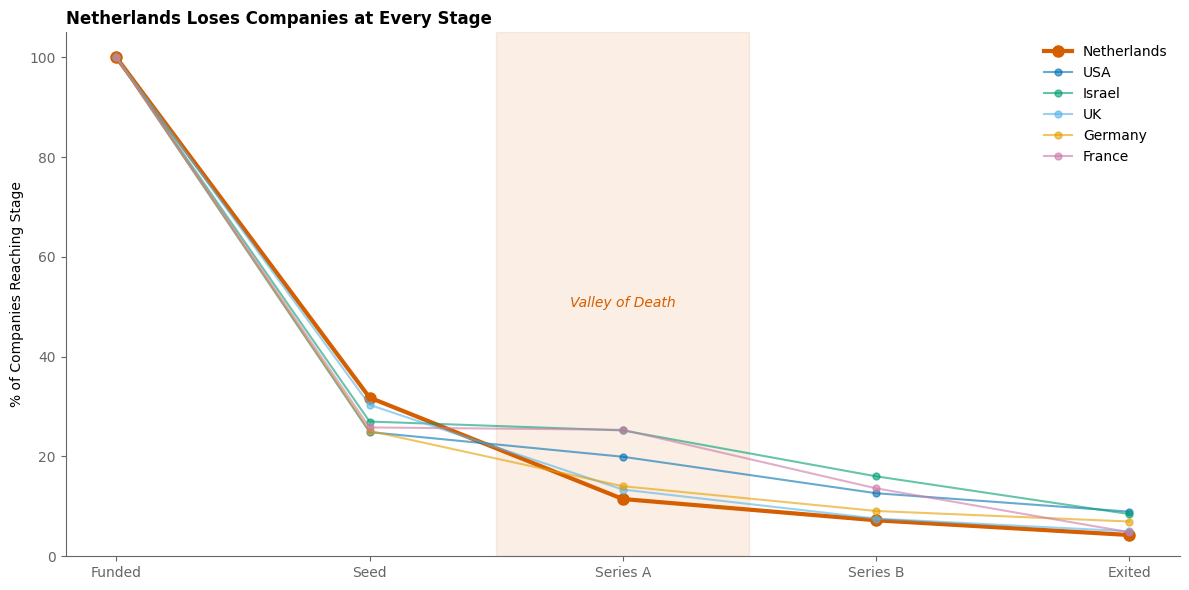

In [48]:
# === CHART #4: sq1_1b_funding_funnel.png (Score: 23) ===
print('CHART #4: Funding Funnel - Valley of Death')

def funding_funnel(country_code):
    subset = df[df['country_code'] == country_code]
    n = len(subset)
    return {
        'Funded': 100,
        'Seed': subset['had_seed'].sum() / n * 100,
        'Series A': subset['had_series_a'].sum() / n * 100,
        'Series B': subset['had_series_b'].sum() / n * 100,
        'Exited': subset['exited'].sum() / n * 100
    }

fig, ax = plt.subplots(figsize=(12, 6))
tufte_style(ax)
stages = ['Funded', 'Seed', 'Series A', 'Series B', 'Exited']
x = np.arange(len(stages))

for code, name in COUNTRIES.items():
    funnel = funding_funnel(code)
    values = [funnel[s] for s in stages]
    linewidth = 3 if code == 'NLD' else 1.5
    alpha = 1.0 if code == 'NLD' else 0.6
    ax.plot(x, values, marker='o', label=name, color=country_colors[name], 
            linewidth=linewidth, alpha=alpha, markersize=8 if code == 'NLD' else 5)

ax.set_xticks(x)
ax.set_xticklabels(stages)
ax.set_ylabel('% of Companies Reaching Stage')
ax.set_title('Netherlands Loses Companies at Every Stage', fontweight='bold', loc='left')
ax.legend(loc='upper right', frameon=False)
ax.set_ylim(0, 105)
ax.axvspan(1.5, 2.5, alpha=0.1, color=COLORS['failure'])
ax.text(2, 50, 'Valley of Death', ha='center', fontsize=10, color=COLORS['failure'], style='italic')
plt.tight_layout()
plt.show()

CHART #5: Survival Funnel with Series C


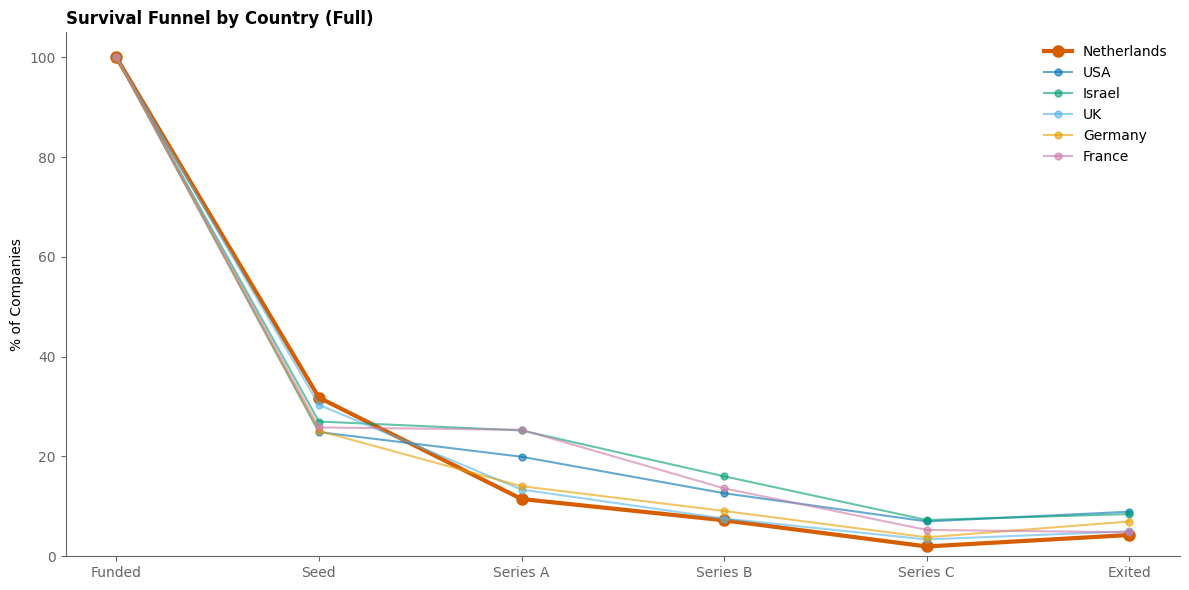

In [49]:
# === CHART #5: survival_funnel.png (Score: 23) ===
print('CHART #5: Survival Funnel with Series C')

def funding_funnel_full(country_code):
    subset = df[df['country_code'] == country_code]
    n = len(subset)
    return {
        'Funded': 100,
        'Seed': subset['had_seed'].sum() / n * 100,
        'Series A': subset['had_series_a'].sum() / n * 100,
        'Series B': subset['had_series_b'].sum() / n * 100,
        'Series C': subset['had_series_c'].sum() / n * 100,
        'Exited': subset['exited'].sum() / n * 100
    }

fig, ax = plt.subplots(figsize=(12, 6))
tufte_style(ax)
stages = ['Funded', 'Seed', 'Series A', 'Series B', 'Series C', 'Exited']
x = np.arange(len(stages))

for code, name in COUNTRIES.items():
    funnel = funding_funnel_full(code)
    values = [funnel[s] for s in stages]
    linewidth = 3 if code == 'NLD' else 1.5
    alpha = 1.0 if code == 'NLD' else 0.6
    ax.plot(x, values, marker='o', label=name, color=country_colors[name], 
            linewidth=linewidth, alpha=alpha, markersize=8 if code == 'NLD' else 5)

ax.set_xticks(x)
ax.set_xticklabels(stages)
ax.set_ylabel('% of Companies')
ax.set_title('Survival Funnel by Country (Full)', fontweight='bold', loc='left')
ax.legend(loc='upper right', frameon=False)
ax.set_ylim(0, 105)
plt.tight_layout()
plt.show()

CHART #6: Timing vs Outcomes


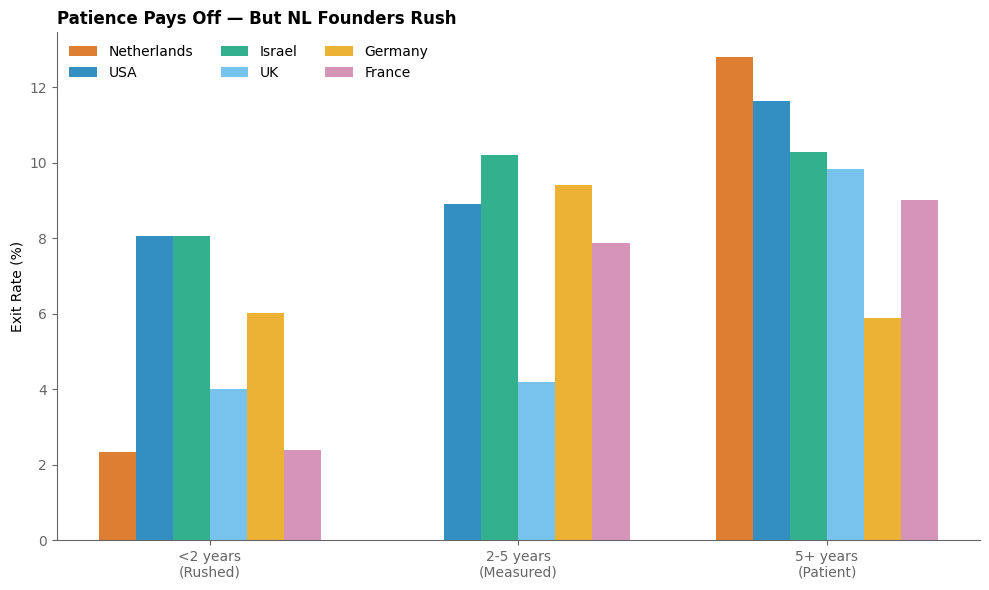

In [50]:
# === CHART #6: sq1_2b_timing_outcomes.png (Score: 22) ===
print('CHART #6: Timing vs Outcomes')

def outcome_by_timing(country_code, timing_range):
    subset = df_timing[(df_timing['country_code'] == country_code) & 
                       (df_timing['years_to_funding'] >= timing_range[0]) &
                       (df_timing['years_to_funding'] < timing_range[1])]
    if len(subset) == 0: return 0
    return subset['exited'].sum() / len(subset) * 100

timing_ranges = [(0, 2), (2, 5), (5, 15)]
timing_labels = ['<2 years\n(Rushed)', '2-5 years\n(Measured)', '5+ years\n(Patient)']

fig, ax = plt.subplots(figsize=(10, 6))
tufte_style(ax)
x = np.arange(len(timing_labels))
width = 0.12

for i, (code, name) in enumerate(COUNTRIES.items()):
    rates = [outcome_by_timing(code, tr) for tr in timing_ranges]
    color = country_colors[name]
    ax.bar(x + i*width, rates, width, label=name, color=color, alpha=0.8)

ax.set_xticks(x + width * 2.5)
ax.set_xticklabels(timing_labels)
ax.set_ylabel('Exit Rate (%)')
ax.set_title('Patience Pays Off — But NL Founders Rush', fontweight='bold', loc='left')
ax.legend(loc='upper left', frameon=False, ncol=3)
plt.tight_layout()
plt.show()

CHART #7: Stage-to-Stage Conversion Rates


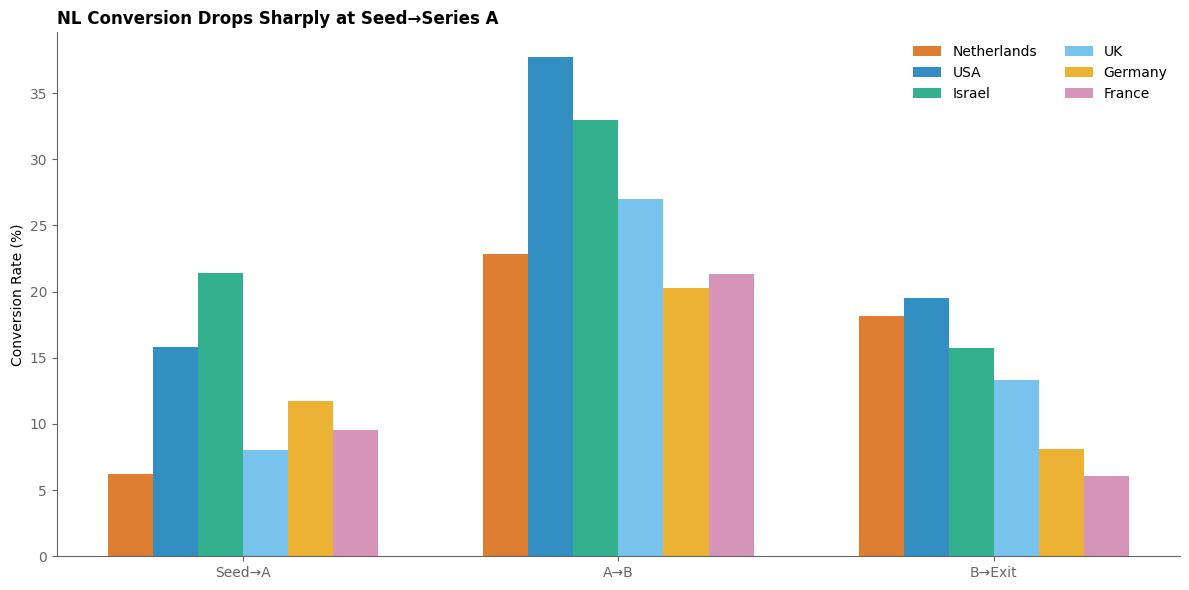

In [51]:
# === CHART #7: conversion_rates.png (Score: 22) ===
print('CHART #7: Stage-to-Stage Conversion Rates')

def conversion_rates(country_code):
    subset = df[df['country_code'] == country_code]
    with_seed = subset[subset['had_seed']]
    with_a = subset[subset['had_series_a']]
    with_b = subset[subset['had_series_b']]
    
    seed_to_a = with_seed['had_series_a'].sum() / len(with_seed) * 100 if len(with_seed) > 0 else 0
    a_to_b = with_a['had_series_b'].sum() / len(with_a) * 100 if len(with_a) > 0 else 0
    b_to_exit = with_b['exited'].sum() / len(with_b) * 100 if len(with_b) > 0 else 0
    return {'Seed→A': seed_to_a, 'A→B': a_to_b, 'B→Exit': b_to_exit}

conv_data = {name: conversion_rates(code) for code, name in COUNTRIES.items()}
transitions = ['Seed→A', 'A→B', 'B→Exit']

fig, ax = plt.subplots(figsize=(12, 6))
tufte_style(ax)
x = np.arange(len(transitions))
width = 0.12

for i, (name, data) in enumerate(conv_data.items()):
    values = [data[t] for t in transitions]
    color = country_colors[name]
    ax.bar(x + i*width, values, width, label=name, color=color, alpha=0.8)

ax.set_xticks(x + width * 2.5)
ax.set_xticklabels(transitions)
ax.set_ylabel('Conversion Rate (%)')
ax.set_title('NL Conversion Drops Sharply at Seed→Series A', fontweight='bold', loc='left')
ax.legend(loc='upper right', ncol=2, frameon=False)
plt.tight_layout()
plt.show()

CHART #8: Patient Companies Have Better Outcomes


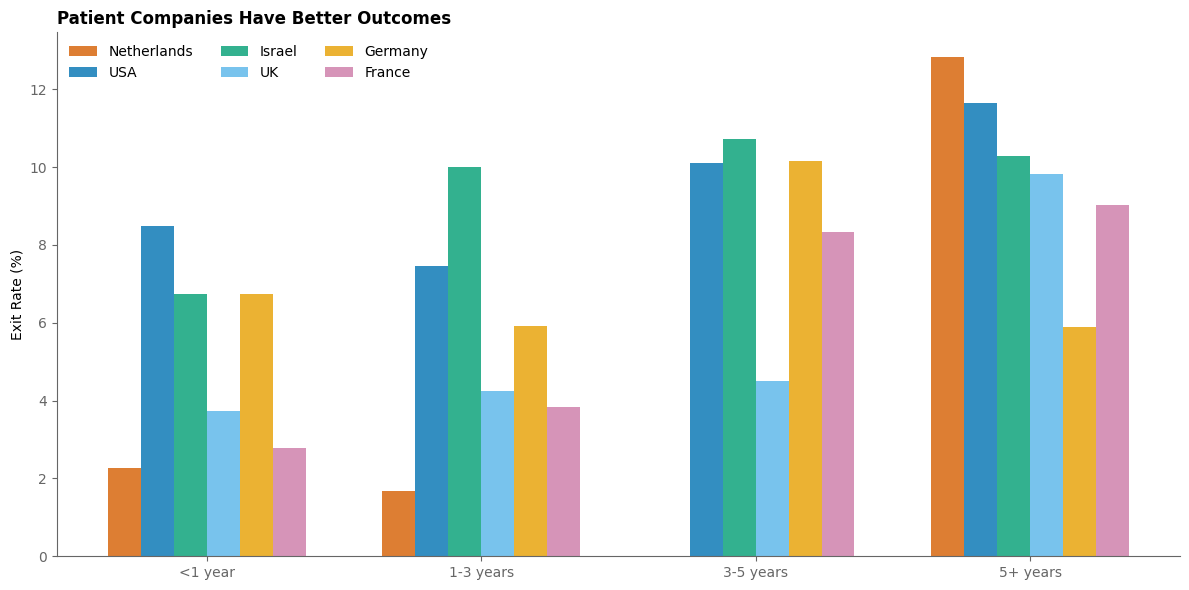

In [52]:
# === CHART #8: timing_vs_outcomes.png (Score: 21) ===
print('CHART #8: Patient Companies Have Better Outcomes')

def outcome_by_first_timing(data, timing_bucket):
    if timing_bucket == 'fast': subset = data[data['years_to_funding'] < 1]
    elif timing_bucket == 'normal': subset = data[(data['years_to_funding'] >= 1) & (data['years_to_funding'] < 3)]
    elif timing_bucket == 'slow': subset = data[(data['years_to_funding'] >= 3) & (data['years_to_funding'] < 5)]
    else: subset = data[data['years_to_funding'] >= 5]
    if len(subset) < 5: return np.nan
    return subset['exited'].mean() * 100

buckets = ['fast', 'normal', 'slow', 'very_slow']
bucket_labels = ['<1 year', '1-3 years', '3-5 years', '5+ years']

results = {}
for code, name in COUNTRIES.items():
    data = df_timing[df_timing['country_code'] == code]
    results[name] = [outcome_by_first_timing(data, b) for b in buckets]

fig, ax = plt.subplots(figsize=(12, 6))
tufte_style(ax)
x = np.arange(len(bucket_labels))
width = 0.12

for i, (name, rates) in enumerate(results.items()):
    color = country_colors[name]
    ax.bar(x + i*width, rates, width, label=name, color=color, alpha=0.8)

ax.set_xticks(x + width * 2.5)
ax.set_xticklabels(bucket_labels)
ax.set_ylabel('Exit Rate (%)')
ax.set_title('Patient Companies Have Better Outcomes', fontweight='bold', loc='left')
ax.legend(loc='upper left', ncol=3, frameon=False)
plt.tight_layout()
plt.show()

CHART #9: What NL Does Well


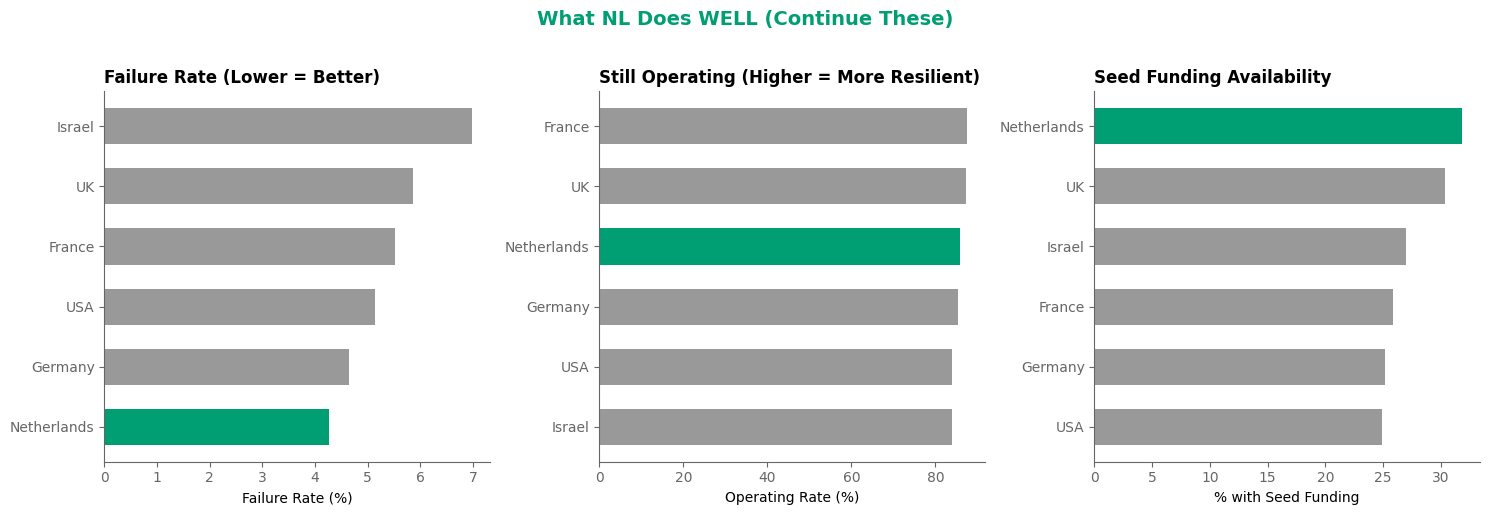

In [53]:
# === CHART #9: part0_strengths.png (Score: 21) ===
print('CHART #9: What NL Does Well')

failure_rates = benchmark_df.groupby('country')['failed'].mean().sort_values() * 100
operating_rates = benchmark_df.groupby('country')['operating'].mean().sort_values(ascending=False) * 100
seed_rates = benchmark_df.groupby('country')['had_seed'].mean().sort_values(ascending=False) * 100

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

ax1 = tufte_style(axes[0])
fail_sorted = failure_rates.sort_values(ascending=False)
colors1 = [COLORS['success'] if c == 'Netherlands' else COLORS['gray'] for c in fail_sorted.index]
ax1.barh(fail_sorted.index, fail_sorted.values, color=colors1, height=0.6)
ax1.set_xlabel('Failure Rate (%)')
ax1.set_title('Failure Rate (Lower = Better)', fontweight='bold', loc='left')
ax1.invert_yaxis()

ax2 = tufte_style(axes[1])
op_sorted = operating_rates.sort_values(ascending=True)
colors2 = [COLORS['success'] if c == 'Netherlands' else COLORS['gray'] for c in op_sorted.index]
ax2.barh(op_sorted.index, op_sorted.values, color=colors2, height=0.6)
ax2.set_xlabel('Operating Rate (%)')
ax2.set_title('Still Operating (Higher = More Resilient)', fontweight='bold', loc='left')

ax3 = tufte_style(axes[2])
seed_sorted = seed_rates.sort_values(ascending=True)
colors3 = [COLORS['success'] if c == 'Netherlands' else COLORS['gray'] for c in seed_sorted.index]
ax3.barh(seed_sorted.index, seed_sorted.values, color=colors3, height=0.6)
ax3.set_xlabel('% with Seed Funding')
ax3.set_title('Seed Funding Availability', fontweight='bold', loc='left')

plt.suptitle('What NL Does WELL (Continue These)', fontsize=14, fontweight='bold', y=1.02, color=COLORS['success'])
plt.tight_layout()
plt.show()

CHART #10: Success Scorecard


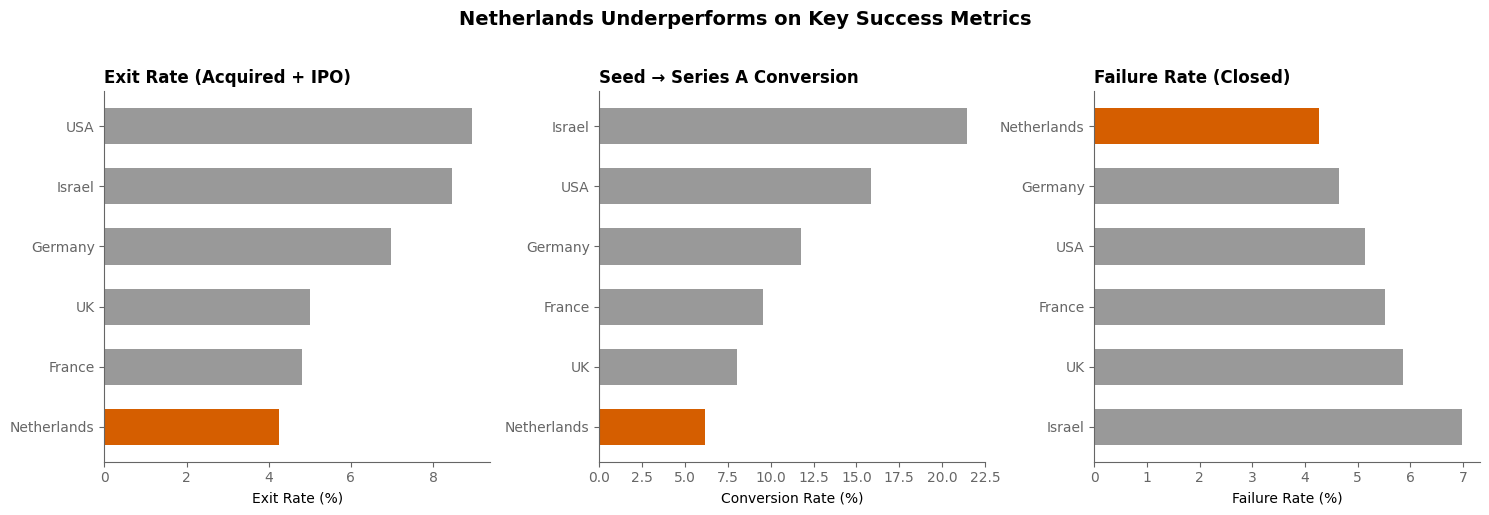

In [54]:
# === CHART #10: sq1_1a_success_scorecard.png (Score: 21) ===
print('CHART #10: Success Scorecard')

def country_metrics(country_code):
    subset = df[df['country_code'] == country_code]
    n = len(subset)
    if n == 0: return None
    return {
        'country': COUNTRIES.get(country_code, country_code),
        'exit_rate': subset['exited'].sum() / n * 100,
        'failure_rate': subset['failed'].sum() / n * 100,
        'seed_to_a': (subset[subset['had_seed']]['had_series_a'].sum() / 
                      subset['had_seed'].sum() * 100) if subset['had_seed'].sum() > 0 else 0
    }

metrics = [country_metrics(c) for c in COUNTRIES.keys()]
metrics_df = pd.DataFrame(metrics).sort_values('exit_rate', ascending=False)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
countries = metrics_df['country'].tolist()
colors = [COLORS['nl'] if c == 'Netherlands' else COLORS['gray'] for c in countries]

ax1 = tufte_style(axes[0])
ax1.barh(countries, metrics_df['exit_rate'], color=colors, height=0.6)
ax1.set_xlabel('Exit Rate (%)')
ax1.set_title('Exit Rate (Acquired + IPO)', fontweight='bold', loc='left')
ax1.invert_yaxis()

ax2 = tufte_style(axes[1])
seed_a = metrics_df.sort_values('seed_to_a', ascending=False)
countries2 = seed_a['country'].tolist()
colors2 = [COLORS['nl'] if c == 'Netherlands' else COLORS['gray'] for c in countries2]
ax2.barh(countries2, seed_a['seed_to_a'], color=colors2, height=0.6)
ax2.set_xlabel('Conversion Rate (%)')
ax2.set_title('Seed → Series A Conversion', fontweight='bold', loc='left')
ax2.invert_yaxis()

ax3 = tufte_style(axes[2])
fail = metrics_df.sort_values('failure_rate', ascending=True)
countries3 = fail['country'].tolist()
colors3 = [COLORS['nl'] if c == 'Netherlands' else COLORS['gray'] for c in countries3]
ax3.barh(countries3, fail['failure_rate'], color=colors3, height=0.6)
ax3.set_xlabel('Failure Rate (%)')
ax3.set_title('Failure Rate (Closed)', fontweight='bold', loc='left')
ax3.invert_yaxis()

plt.suptitle('Netherlands Underperforms on Key Success Metrics', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

---
# TIER 2: STRONG SUPPORTING (Score 17-20)
---

CHART #11: Rounds vs Survival


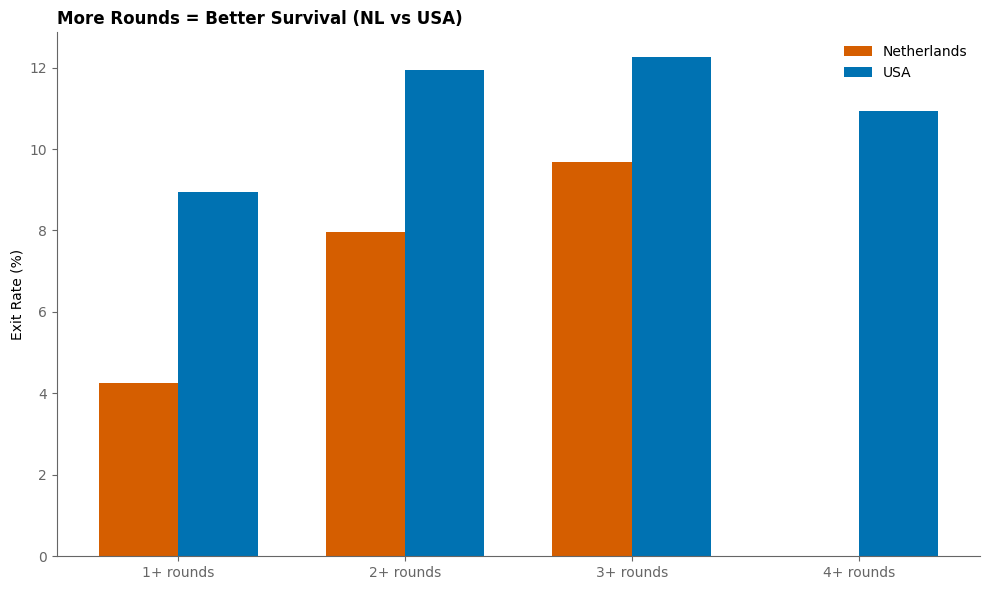

In [55]:
# === CHART #11: rounds_vs_survival.png (Score: 20) ===
print('CHART #11: Rounds vs Survival')

def survival_by_rounds(country_code):
    subset = df[df['country_code'] == country_code]
    results = []
    for rounds in range(1, 6):
        round_subset = subset[subset['funding_rounds'] >= rounds]
        if len(round_subset) < 10: continue
        results.append({'rounds': f'{rounds}+ rounds', 'exit_rate': round_subset['exited'].mean() * 100, 'n': len(round_subset)})
    return results

nl_rounds = pd.DataFrame(survival_by_rounds('NLD'))
us_rounds = pd.DataFrame(survival_by_rounds('USA'))

fig, ax = plt.subplots(figsize=(10, 6))
tufte_style(ax)

if len(nl_rounds) > 0 and len(us_rounds) > 0:
    x = np.arange(len(nl_rounds))
    width = 0.35
    ax.bar(x - width/2, nl_rounds['exit_rate'], width, label='Netherlands', color=COLORS['nl'])
    ax.bar(x + width/2, us_rounds['exit_rate'].values[:len(nl_rounds)], width, label='USA', color=COLORS['usa'])
    ax.set_xticks(x)
    ax.set_xticklabels(nl_rounds['rounds'])
    ax.set_ylabel('Exit Rate (%)')
    ax.set_title('More Rounds = Better Survival (NL vs USA)', fontweight='bold', loc='left')
    ax.legend(frameon=False)

plt.tight_layout()
plt.show()

CHART #12: Average Funding Rounds


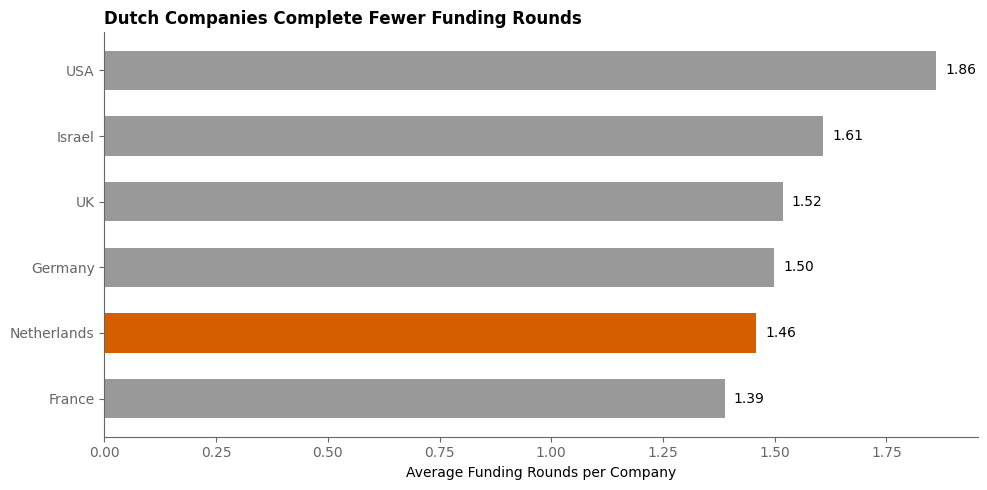

In [56]:
# === CHART #12: sq1_2c_avg_rounds.png (Score: 20) ===
print('CHART #12: Average Funding Rounds')

fig, ax = plt.subplots(figsize=(10, 5))
tufte_style(ax)

rounds_by_country = benchmark_df.groupby('country')['funding_rounds'].mean().sort_values(ascending=True)
colors = [COLORS['nl'] if c == 'Netherlands' else COLORS['gray'] for c in rounds_by_country.index]

bars = ax.barh(rounds_by_country.index, rounds_by_country.values, color=colors, height=0.6)
ax.set_xlabel('Average Funding Rounds per Company')
ax.set_title('Dutch Companies Complete Fewer Funding Rounds', fontweight='bold', loc='left')
for bar, val in zip(bars, rounds_by_country.values):
    ax.text(val + 0.02, bar.get_y() + bar.get_height()/2, f'{val:.2f}', va='center', fontsize=10)

plt.tight_layout()
plt.show()

CHART #13: Policy Priority Ranking


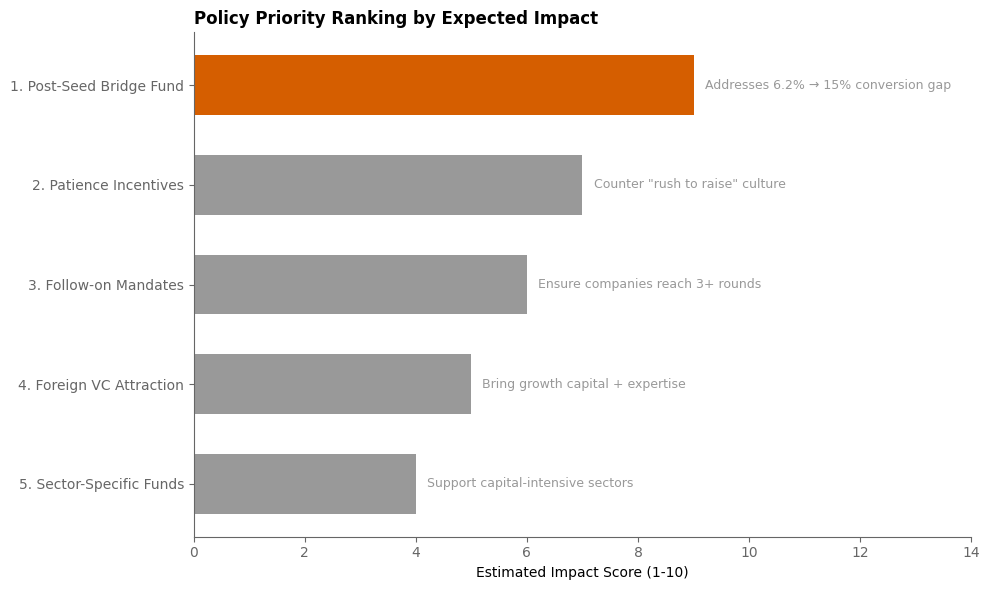

In [57]:
# === CHART #13: sq2_priority_ranking.png (Score: 20) ===
print('CHART #13: Policy Priority Ranking')

fig, ax = plt.subplots(figsize=(10, 6))
tufte_style(ax)

priorities = [
    ('1. Post-Seed Bridge Fund', 9, 'Addresses 6.2% → 15% conversion gap'),
    ('2. Patience Incentives', 7, 'Counter "rush to raise" culture'),
    ('3. Follow-on Mandates', 6, 'Ensure companies reach 3+ rounds'),
    ('4. Foreign VC Attraction', 5, 'Bring growth capital + expertise'),
    ('5. Sector-Specific Funds', 4, 'Support capital-intensive sectors'),
]

names = [p[0] for p in priorities]
impacts = [p[1] for p in priorities]
notes = [p[2] for p in priorities]
colors = [COLORS['nl'] if i == 0 else COLORS['gray'] for i in range(len(priorities))]

bars = ax.barh(names[::-1], impacts[::-1], color=colors[::-1], height=0.6)
for bar, note in zip(bars, notes[::-1]):
    ax.text(bar.get_width() + 0.2, bar.get_y() + bar.get_height()/2, note, va='center', fontsize=9, color=COLORS['gray'])

ax.set_xlabel('Estimated Impact Score (1-10)')
ax.set_title('Policy Priority Ranking by Expected Impact', fontweight='bold', loc='left')
ax.set_xlim(0, 14)
plt.tight_layout()
plt.show()

CHART #14: Funding Diversity vs Outcomes


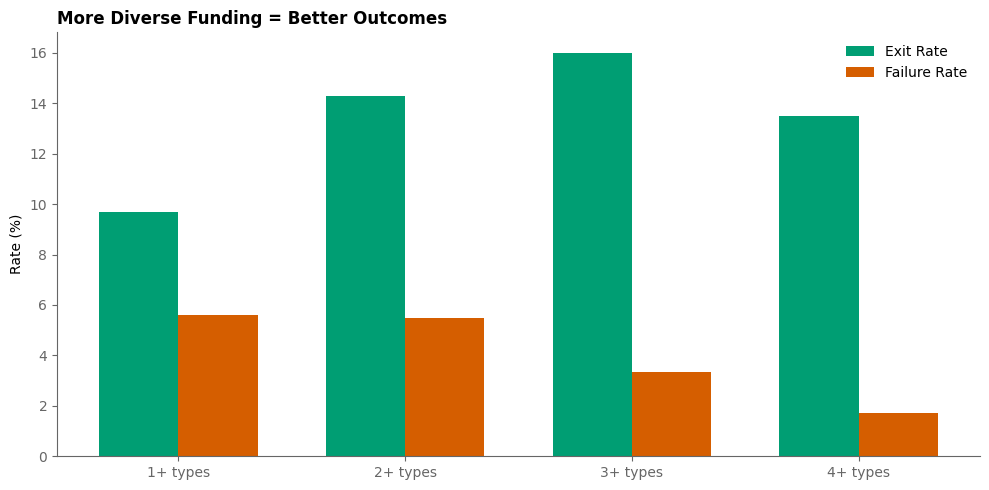

In [58]:
# === CHART #14: diversity_vs_outcomes.png (Score: 20) ===
print('CHART #14: Funding Diversity vs Outcomes')

funding_types = ['seed', 'venture', 'angel', 'round_A', 'round_B']
benchmark_df['funding_diversity'] = benchmark_df[funding_types].apply(lambda x: (x > 0).sum(), axis=1)

diversity_outcomes = []
for div in range(1, 5):
    subset = benchmark_df[benchmark_df['funding_diversity'] >= div]
    if len(subset) >= 50:
        diversity_outcomes.append({
            'diversity': f'{div}+ types',
            'exit_rate': subset['exited'].mean() * 100,
            'fail_rate': subset['failed'].mean() * 100,
            'n': len(subset)
        })

div_df = pd.DataFrame(diversity_outcomes)

fig, ax = plt.subplots(figsize=(10, 5))
tufte_style(ax)

if len(div_df) > 0:
    x = np.arange(len(div_df))
    width = 0.35
    ax.bar(x - width/2, div_df['exit_rate'], width, label='Exit Rate', color=COLORS['success'])
    ax.bar(x + width/2, div_df['fail_rate'], width, label='Failure Rate', color=COLORS['failure'])
    ax.set_xticks(x)
    ax.set_xticklabels(div_df['diversity'])
    ax.set_ylabel('Rate (%)')
    ax.set_title('More Diverse Funding = Better Outcomes', fontweight='bold', loc='left')
    ax.legend(frameon=False)

plt.tight_layout()
plt.show()

CHART #15: Total Funding Comparison


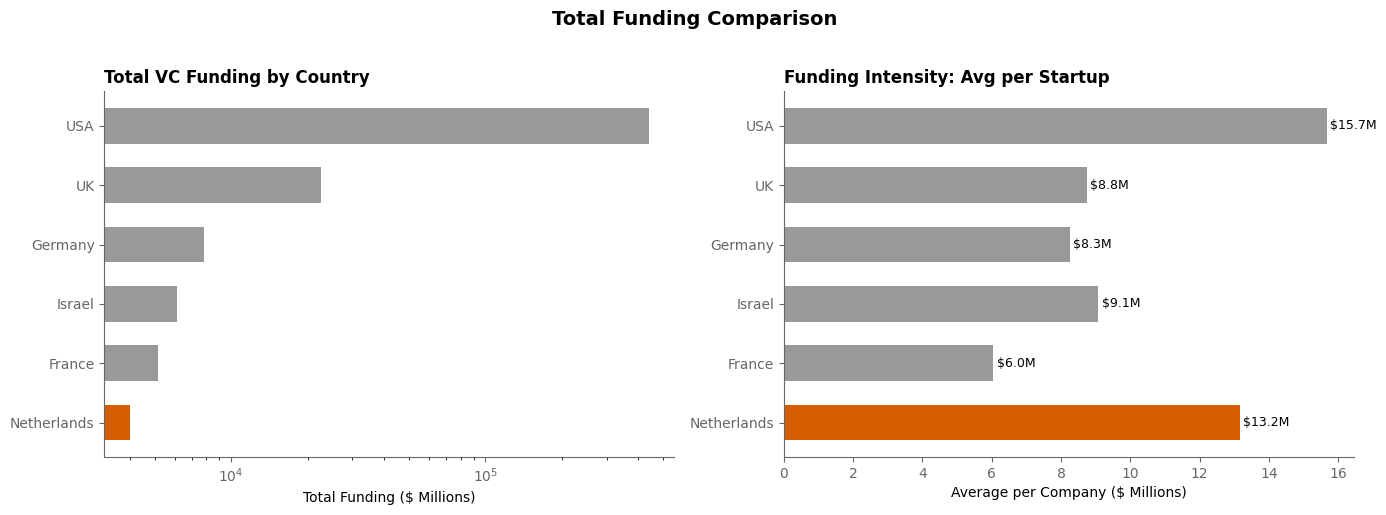

In [59]:
# === CHART #15: finding7_funding_comparison.png (Score: 19) ===
print('CHART #15: Total Funding Comparison')

def funding_stats(codes, label):
    if isinstance(codes, str): codes = [codes]
    subset = df[df['country_code'].isin(codes)]
    total = subset['funding_total_usd'].sum()
    count = len(subset)
    return {'Region': label, 'Companies': count, 'Total Funding ($M)': total / 1e6, 
            'Avg per Company ($M)': (total / count) / 1e6 if count > 0 else 0}

regions_compare = [(['USA'], 'USA'), (['ISR'], 'Israel'), (['GBR'], 'UK'), 
                   (['DEU'], 'Germany'), (['FRA'], 'France'), (['NLD'], 'Netherlands')]

funding_data = [funding_stats(codes, label) for codes, label in regions_compare]
funding_df = pd.DataFrame(funding_data).sort_values('Total Funding ($M)', ascending=False)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax1 = tufte_style(axes[0])
regions_sorted = funding_df['Region'].tolist()
totals = funding_df['Total Funding ($M)'].tolist()
colors = [COLORS['nl'] if r == 'Netherlands' else COLORS['gray'] for r in regions_sorted]
ax1.barh(regions_sorted[::-1], totals[::-1], color=colors[::-1], height=0.6)
ax1.set_xlabel('Total Funding ($ Millions)')
ax1.set_title('Total VC Funding by Country', fontweight='bold', loc='left')
ax1.set_xscale('log')

ax2 = tufte_style(axes[1])
per_company = funding_df['Avg per Company ($M)'].tolist()
bars2 = ax2.barh(regions_sorted[::-1], per_company[::-1], color=colors[::-1], height=0.6)
for bar, val in zip(bars2, per_company[::-1]):
    ax2.text(val + 0.1, bar.get_y() + bar.get_height()/2, f'${val:.1f}M', va='center', fontsize=9)
ax2.set_xlabel('Average per Company ($ Millions)')
ax2.set_title('Funding Intensity: Avg per Startup', fontweight='bold', loc='left')

plt.suptitle('Total Funding Comparison', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

CHART #16: Round Sizes by Country


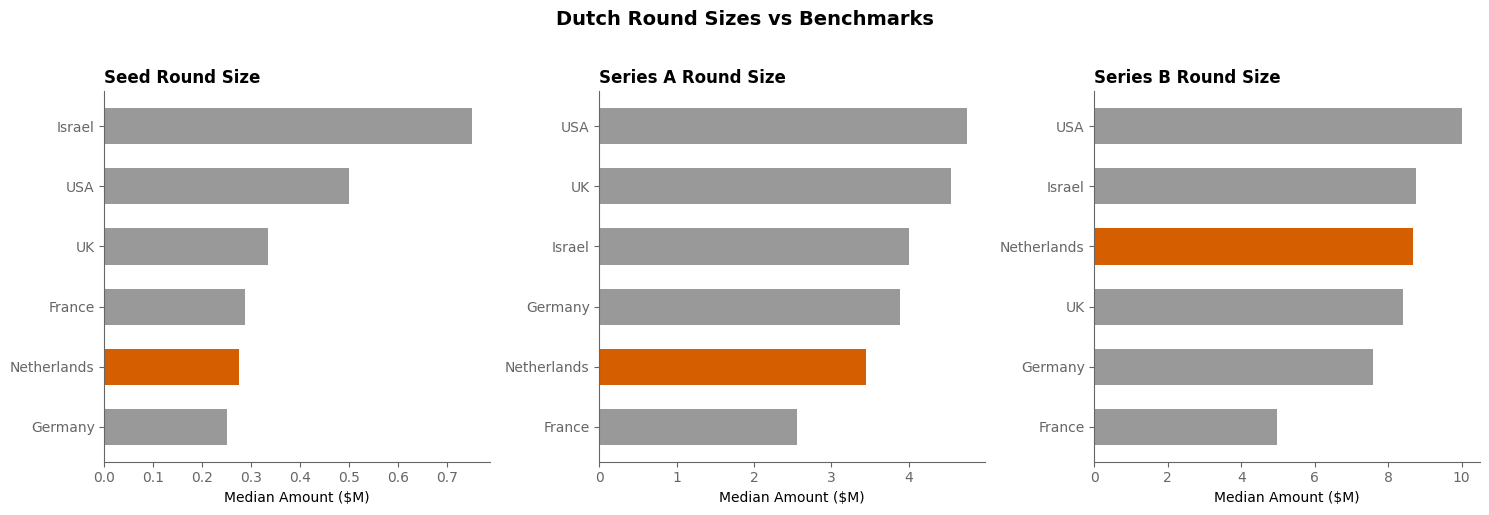

In [60]:
# === CHART #16: sq1_2a_round_sizes.png (Score: 19) ===
print('CHART #16: Round Sizes by Country')

def funding_amounts(country_code):
    subset = df[df['country_code'] == country_code]
    return {
        'country': COUNTRIES.get(country_code, country_code),
        'median_seed': subset[subset['seed'] > 0]['seed'].median() / 1e6,
        'median_series_a': subset[subset['round_A'] > 0]['round_A'].median() / 1e6,
        'median_series_b': subset[subset['round_B'] > 0]['round_B'].median() / 1e6,
    }

funding_amounts_df = pd.DataFrame([funding_amounts(c) for c in COUNTRIES.keys()])

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
rounds = ['median_seed', 'median_series_a', 'median_series_b']
titles = ['Seed Round Size', 'Series A Round Size', 'Series B Round Size']

for i, (col, title) in enumerate(zip(rounds, titles)):
    ax = tufte_style(axes[i])
    sorted_df = funding_amounts_df.sort_values(col, ascending=True)
    countries = sorted_df['country'].tolist()
    values = sorted_df[col].tolist()
    colors = [COLORS['nl'] if c == 'Netherlands' else COLORS['gray'] for c in countries]
    ax.barh(countries, values, color=colors, height=0.6)
    ax.set_xlabel('Median Amount ($M)')
    ax.set_title(title, fontweight='bold', loc='left')

plt.suptitle('Dutch Round Sizes vs Benchmarks', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

CHART #17: NL Timing Impact


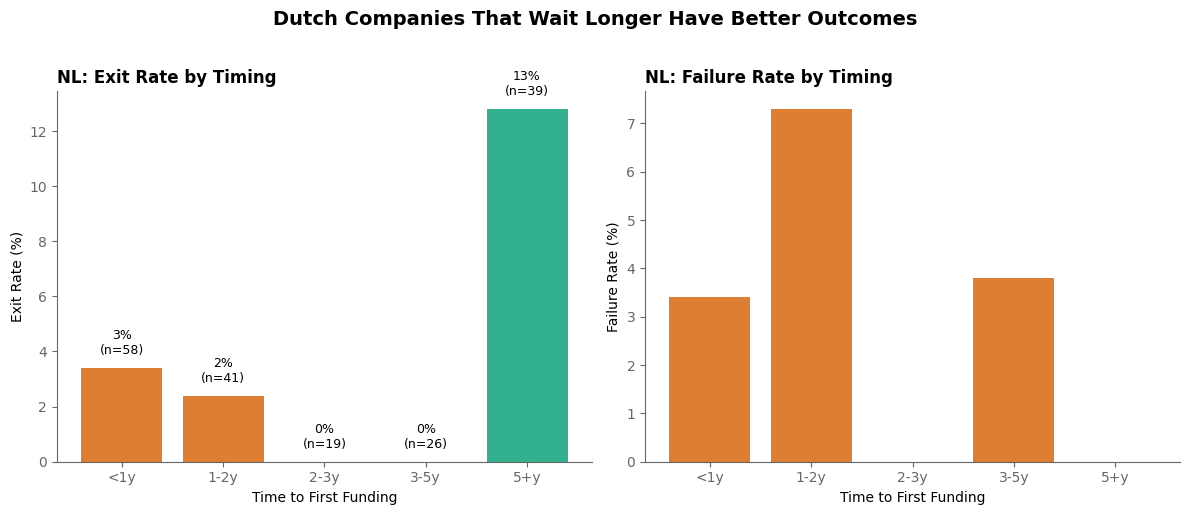

In [61]:
# === CHART #17: nl_timing_impact.png (Score: 19) ===
print('CHART #17: NL Timing Impact')

nl_timing = df_timing[df_timing['country_code'] == 'NLD'].copy()
nl_timing['timing_bucket'] = pd.cut(nl_timing['years_to_funding'], 
                                     bins=[0, 1, 2, 3, 5, 15],
                                     labels=['<1y', '1-2y', '2-3y', '3-5y', '5+y'])

nl_timing_outcomes = nl_timing.groupby('timing_bucket', observed=False).agg({
    'exited': 'mean', 'failed': 'mean', 'country_code': 'count'
}).round(3)
nl_timing_outcomes.columns = ['exit_rate', 'fail_rate', 'n']
nl_timing_outcomes['exit_rate'] *= 100
nl_timing_outcomes['fail_rate'] *= 100

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

ax1 = tufte_style(axes[0])
buckets = nl_timing_outcomes.index.tolist()
exit_rates = nl_timing_outcomes['exit_rate'].values
ns = nl_timing_outcomes['n'].values
colors1 = [COLORS['success'] if e > nl_timing_outcomes['exit_rate'].mean() else COLORS['failure'] for e in exit_rates]
bars1 = ax1.bar(buckets, exit_rates, color=colors1, alpha=0.8)
for bar, val, n in zip(bars1, exit_rates, ns):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5, f'{val:.0f}%\n(n={n})', ha='center', fontsize=9)
ax1.set_xlabel('Time to First Funding')
ax1.set_ylabel('Exit Rate (%)')
ax1.set_title('NL: Exit Rate by Timing', fontweight='bold', loc='left')

ax2 = tufte_style(axes[1])
fail_rates = nl_timing_outcomes['fail_rate'].values
colors2 = [COLORS['failure'] if f > nl_timing_outcomes['fail_rate'].mean() else COLORS['success'] for f in fail_rates]
ax2.bar(buckets, fail_rates, color=colors2, alpha=0.8)
ax2.set_xlabel('Time to First Funding')
ax2.set_ylabel('Failure Rate (%)')
ax2.set_title('NL: Failure Rate by Timing', fontweight='bold', loc='left')

plt.suptitle('Dutch Companies That Wait Longer Have Better Outcomes', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

CHART #18: Living Dead Rate


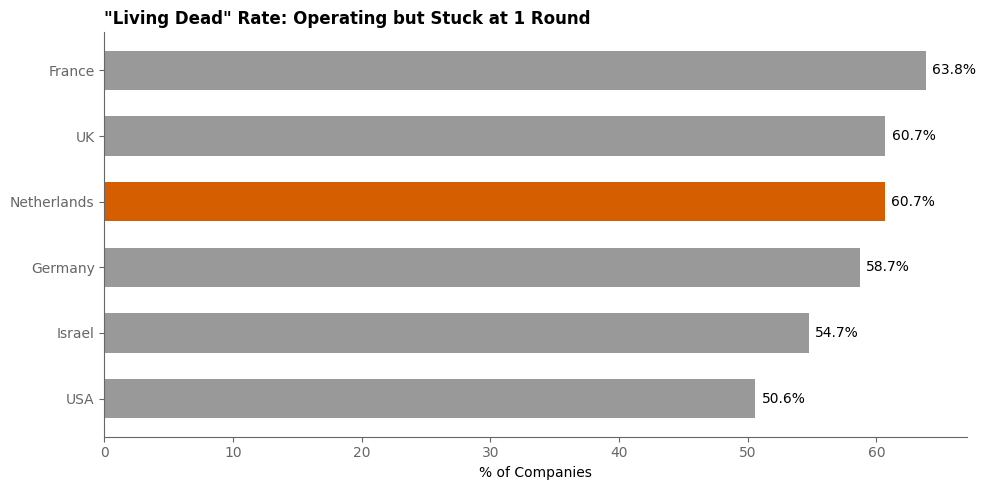

In [62]:
# === CHART #18: living_dead.png (Score: 19) ===
print('CHART #18: Living Dead Rate')

benchmark_df['living_dead'] = (benchmark_df['status'] == 'operating') & (benchmark_df['funding_rounds'] == 1)
living_dead_rate = benchmark_df.groupby('country')['living_dead'].mean() * 100
living_dead_rate = living_dead_rate.sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(10, 5))
tufte_style(ax)

countries = living_dead_rate.index.tolist()
rates = living_dead_rate.values
colors = [COLORS['nl'] if c == 'Netherlands' else COLORS['gray'] for c in countries]

bars = ax.barh(countries[::-1], rates[::-1], color=colors[::-1], height=0.6)
for bar, val in zip(bars, rates[::-1]):
    ax.text(val + 0.5, bar.get_y() + bar.get_height()/2, f'{val:.1f}%', va='center')

ax.set_xlabel('% of Companies')
ax.set_title('"Living Dead" Rate: Operating but Stuck at 1 Round', fontweight='bold', loc='left')
plt.tight_layout()
plt.show()

CHART #19: Funding Statistics by Country


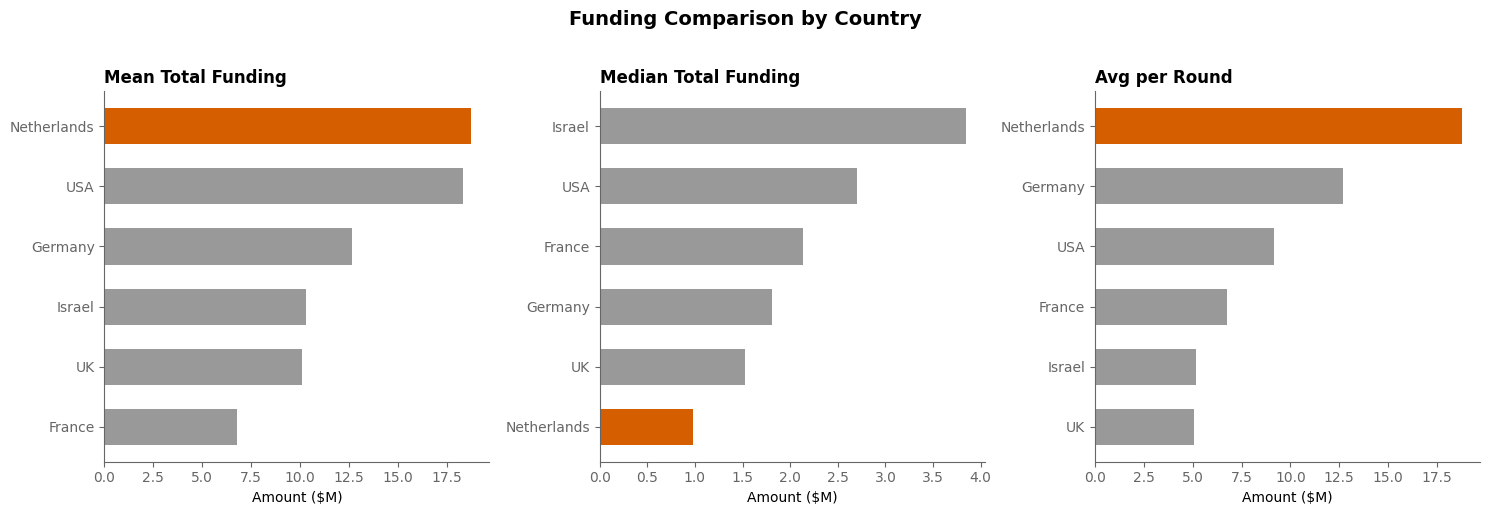

In [63]:
# === CHART #19: funding_by_country.png (Score: 19) ===
print('CHART #19: Funding Statistics by Country')

funding_stats_df = benchmark_df.groupby('country').agg({
    'funding_total_usd': ['mean', 'median'],
    'funding_rounds': 'mean'
}).round(0)
funding_stats_df.columns = ['mean_funding', 'median_funding', 'avg_rounds']
funding_stats_df['per_round'] = funding_stats_df['mean_funding'] / funding_stats_df['avg_rounds']

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, (col, title) in enumerate([('mean_funding', 'Mean Total Funding'), 
                                   ('median_funding', 'Median Total Funding'), 
                                   ('per_round', 'Avg per Round')]):
    ax = tufte_style(axes[i])
    sorted_df = funding_stats_df.sort_values(col, ascending=True)
    countries = sorted_df.index.tolist()
    values = sorted_df[col].values / 1e6
    colors = [COLORS['nl'] if c == 'Netherlands' else COLORS['gray'] for c in countries]
    ax.barh(countries, values, color=colors, height=0.6)
    ax.set_xlabel('Amount ($M)')
    ax.set_title(title, fontweight='bold', loc='left')

plt.suptitle('Funding Comparison by Country', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

CHART #20: Sector Performance Gap


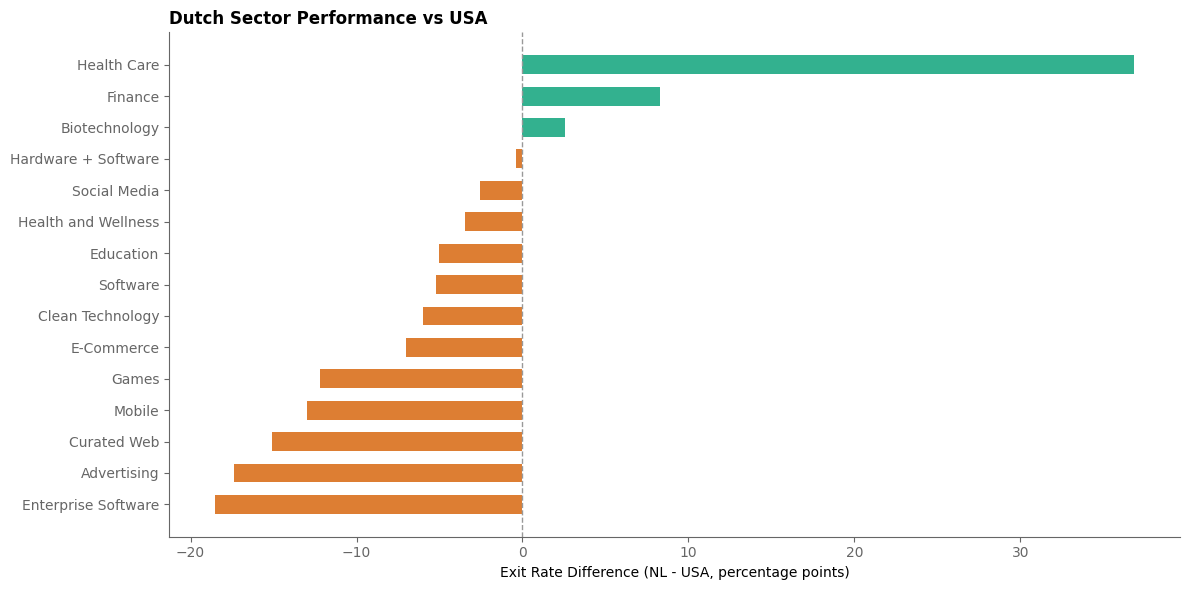

In [64]:
# === CHART #20: sq1_3_sector_gap.png (Score: 18) ===
print('CHART #20: Sector Performance Gap')

top_sectors = df['market'].value_counts().head(15).index.tolist()

def sector_exit_rate(country_code, sector):
    subset = df[(df['country_code'] == country_code) & (df['market'] == sector)]
    if len(subset) < 5: return np.nan, 0
    return subset['exited'].sum() / len(subset) * 100, len(subset)

sector_comparison = []
for sector in top_sectors:
    nl_rate, nl_n = sector_exit_rate('NLD', sector)
    us_rate, us_n = sector_exit_rate('USA', sector)
    if pd.notna(nl_rate) and pd.notna(us_rate):
        sector_comparison.append({'sector': sector, 'nl_exit': nl_rate, 'us_exit': us_rate, 
                                  'nl_vs_us': nl_rate - us_rate, 'nl_n': nl_n})

if sector_comparison:
    sector_df = pd.DataFrame(sector_comparison).sort_values('nl_vs_us', ascending=False)
    
    fig, ax = plt.subplots(figsize=(12, 6))
    tufte_style(ax)
    
    sectors = sector_df['sector'].tolist()
    gaps = sector_df['nl_vs_us'].tolist()
    colors = [COLORS['success'] if g > 0 else COLORS['failure'] for g in gaps]
    
    ax.barh(sectors, gaps, color=colors, height=0.6, alpha=0.8)
    ax.axvline(x=0, color=COLORS['gray'], linewidth=1, linestyle='--')
    ax.set_xlabel('Exit Rate Difference (NL - USA, percentage points)')
    ax.set_title('Dutch Sector Performance vs USA', fontweight='bold', loc='left')
    ax.invert_yaxis()
    
    plt.tight_layout()
    plt.show()

---
# SUMMARY: Your Top 3 Charts

Based on the ranking, these are your **TOP 3 charts for the 2-page report**:

1. **Chart #1: Graduation Gap** (Score 24) - NL 6.2% vs Israel 21%
2. **Chart #2: Rounds Matter** (Score 24) - 4+ rounds = 3x better outcomes
3. **Chart #3: Tortoise Effect** (Score 24) - Rushing hurts NL most

## Key Numbers to Memorize

| Metric | NL | USA | Israel |
|--------|-----|-----|--------|
| Seed→A rate | 6.2% | 15.8% | 21.4% |
| Exit rate | 4.3% | 8.9% | 8.5% |
| Avg rounds | 1.46 | 1.86 | 1.93 |
| Companies | 305 | 28,006 | 674 |

---

**Run all cells above to see all 20 key charts.**
---